Total samples after cleaning: 69
Up days: 31, Down days: 38 (Up 44.9%, Down 55.1%)
Sequence shape: (64, 5, 5) (num_sequences, 5 days, 5 features)
Train sequences: 36, Val sequences: 13, Test sequences: 15
Epoch 001: train_loss=0.7075, train_acc=0.31, val_loss=0.7075, val_acc=0.23
Epoch 010: train_loss=0.5747, train_acc=0.64, val_loss=1.2834, val_acc=0.31
Epoch 020: train_loss=0.1324, train_acc=0.92, val_loss=3.5185, val_acc=0.15
Epoch 030: train_loss=0.0122, train_acc=1.00, val_loss=4.4065, val_acc=0.15
Epoch 040: train_loss=0.0038, train_acc=1.00, val_loss=4.5714, val_acc=0.23
Epoch 050: train_loss=0.0028, train_acc=1.00, val_loss=4.7759, val_acc=0.23
Epoch 060: train_loss=0.0015, train_acc=1.00, val_loss=4.9431, val_acc=0.31
Epoch 070: train_loss=0.0010, train_acc=1.00, val_loss=5.0275, val_acc=0.31
Epoch 080: train_loss=0.0010, train_acc=1.00, val_loss=5.1334, val_acc=0.31
Epoch 090: train_loss=0.0006, train_acc=1.00, val_loss=5.2606, val_acc=0.31
Epoch 100: train_loss=0.0007, train

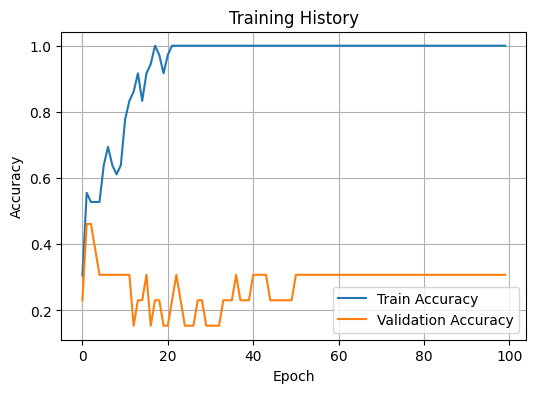

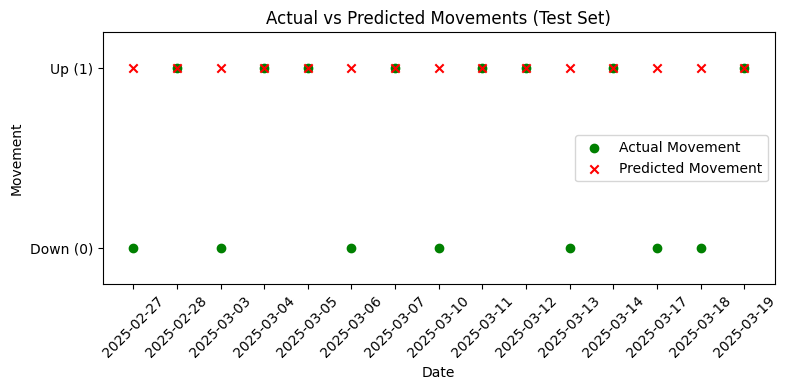

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. LOAD DATA
df = pd.read_csv('../data/00/merged/sentiment_stock_merged_TSLA.csv')
# Drop days with no stock data (e.g., weekends with sentiment but no trading next day)
df = df.dropna(subset=['Open', 'Close']).copy().reset_index(drop=True)

# 2. FEATURE ENGINEERING
# Create binary target: 1 if Close > Open (up day), else 0 (down day)
df['Movement'] = (df['Close'] > df['Open']).astype(int)
# Calculate daily return and intraday range as additional features
df['Return'] = (df['Close'] - df['Open']) / df['Open']  # e.g., 0.01 = 1% gain from open to close
df['Range']  = (df['High'] - df['Low']) / df['Open']    # intraday volatility range

# Label distribution
up_days = df['Movement'].sum()
down_days = len(df) - up_days
print(f"Total samples after cleaning: {len(df)}")
print(f"Up days: {up_days}, Down days: {down_days} (Up {up_days/len(df):.1%}, Down {down_days/len(df):.1%})")

# 3. SELECT FEATURES for the model
features = ['posts_per_day', 'avg_sentiment', 'Return', 'Range', 'Volume']
X_all = df[features].astype(float).values  # ensure float for scaling
y_all = df['Movement'].values

# 4. FEATURE SCALING
# Use only training portion to fit the scaler (to avoid look-ahead bias)
# We'll decide splits by index (chronologically). Let's say 60% train, 20% val, 20% test.
total = len(df)
train_size = int(0.6 * total)   # index range 0 .. train_size-1 for training data
val_size   = int(0.2 * total)   # next 20% for validation
# (the rest will be test)
# Fit scaler on training data (all features across the training period)
scaler = StandardScaler()
scaler.fit(X_all[:train_size, :])
X_all_scaled = scaler.transform(X_all)

# 5. CREATE SEQUENCES FOR LSTM
seq_length = 5  # number of days in the input sequence
X_sequences = []
y_sequences = []
# We predict each day (from seq_length onwards) using the previous seq_length days of data
for i in range(seq_length, len(df)):
    X_sequences.append(X_all_scaled[i-seq_length:i, :])
    y_sequences.append(y_all[i])
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)
print(f"Sequence shape: {X_sequences.shape} (num_sequences, {seq_length} days, {X_sequences.shape[2]} features)")

# Determine split indices for sequences corresponding to the above time splits.
# The first sequence corresponds to label index `seq_length` (because we need that many prior days).
first_label_index = seq_length  # this index in original data is the first that has a sequence
# Train sequences cover original label indices [seq_length .. train_size-1]
train_seq_count = train_size - seq_length
val_seq_count   = val_size
# Test sequences cover the remainder
test_seq_count  = len(X_sequences) - train_seq_count - val_seq_count

# Split the sequences and labels
X_train = X_sequences[:train_seq_count]
y_train = y_sequences[:train_seq_count]
X_val   = X_sequences[train_seq_count:train_seq_count+val_seq_count]
y_val   = y_sequences[train_seq_count:train_seq_count+val_seq_count]
X_test  = X_sequences[train_seq_count+val_seq_count:]
y_test  = y_sequences[train_seq_count+val_seq_count:]
print(f"Train sequences: {X_train.shape[0]}, Val sequences: {X_val.shape[0]}, Test sequences: {X_test.shape[0]}")

# 6. PREPARE TORCH DATA LOADERS
# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)
# Create Dataset and DataLoader for batching
train_dataset = TensorDataset(X_train_t, y_train_t)
# We'll shuffle training sequences each epoch for better generalization
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False)

# 7. DEFINE LSTM MODEL ARCHITECTURE
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                             batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)  # output a single logit for binary classification
    def forward(self, x):
        # x shape: (batch, seq_length, input_dim)
        lstm_out, _ = self.lstm(x)            # lstm_out: (batch, seq_length, hidden_dim)
        last_out = lstm_out[:, -1, :]         # get output of last time step
        logit = self.fc(last_out)             # shape: (batch, 1)
        return logit.squeeze(1)              # shape: (batch,) – logits for each sample

# Instantiate model
input_dim = X_train.shape[2]
model = LSTMClassifier(input_dim=input_dim, hidden_dim=16, num_layers=2, dropout=0.2)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 8. TRAIN THE MODEL
epochs = 100
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    correct = total_samples = 0
    # Train in batches
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)            # forward pass
        loss = criterion(logits, y_batch)  # compute loss
        loss.backward()
        optimizer.step()
        # accumulate training stats
        epoch_loss += loss.item() * len(X_batch)
        # Compute batch accuracy
        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds.view(-1) == y_batch.long()).sum().item()
        total_samples += len(X_batch)
    # Compute epoch average loss and accuracy
    train_loss = epoch_loss / total_samples
    train_acc = correct / total_samples

    # Validation performance
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = criterion(val_logits, y_val_t).item()
        val_preds = (torch.sigmoid(val_logits) >= 0.5).long()
        val_acc = (val_preds.view(-1) == y_val_t.long()).sum().item() / len(y_val_t)
    # Record history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # Print progress occasionally
    if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
        print(f"Epoch {epoch:03d}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}, "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.2f}")

# 9. EVALUATION ON TEST SET
model.eval()
with torch.no_grad():
    test_logits = model(X_test_t)
    test_probs = torch.sigmoid(test_logits).numpy().flatten()
    test_pred_labels = (test_probs >= 0.5).astype(int)
test_acc = (test_pred_labels == y_test).mean()
print(f"Test Accuracy: {test_acc:.2%}")

# 10. PLOT TRAINING HISTORY (accuracy over epochs)
plt.figure(figsize=(6,4))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 11. PLOT ACTUAL vs PREDICTED on TEST SET
plt.figure(figsize=(8,4))
test_dates = df['date_only_stock'].iloc[train_size + val_size:]  # dates corresponding to test period
x = np.arange(len(test_pred_labels))
# Plot actual movements
plt.scatter(x, y_test, marker='o', color='green', label='Actual Movement')
# Plot predicted movements
plt.scatter(x, test_pred_labels, marker='x', color='red', label='Predicted Movement')
plt.yticks([0, 1], ['Down (0)', 'Up (1)'])
plt.xticks(x, test_dates, rotation=45)
plt.ylim(-0.2, 1.2)
plt.xlabel('Date')
plt.ylabel('Movement')
plt.title('Actual vs Predicted Movements (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()
